# Introduction

## Dataset

https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0003

Number of students in Germany by subject of study, nationality, gender from 2018-2024. I will focus on the final year 2023/24 for a start. (Will I?)

Check this document for official practice of subject codes and subject cluster classifications: https://www.destatis.de/DE/Methoden/Klassifikationen/Bildung/studenten-pruefungsstatistik.pst_all?__blob=publicationFile&v=12

## Questions 

1. What was the total number of students in Germany in 2023/24?
2. What were the 10 subjects with the highest number of students in 2023/24?
3. How was the gender distribution of students in 2023/24?
4. How was the gender distribution in the 5 most studied subjects?
5. What were the top subjects by gender?
6. Which were the top 5 subjects studied by non-citizens? 
7. (Sort the subjects into clusters and provide a cluster identifier to the dataframe.) How are the student numbers distributed across subject clusters?
8. How does the number of students change over the time period by cluster?
9. How does the number of students change over the time period for language related subjects?
10. How does the number of students change for linguistics in a narrow perspective?





# Setup

## Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json


In [2]:
# disable scientific notation

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.use_mathtext'] = False

In [3]:
# visualisation settings

# allow unlimited scrollability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set_theme(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

## Load dataset(s)

In [4]:
# fields of study, all Germany 2018-2024
# using the non-flat csv
# https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0003
stud = pd.read_csv('./datasets/raw/21311-0003_de_flat_allstudents.csv',sep=';')

# for alternative table with data per state see:
# https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0006

In [5]:
# additional datasets
# freshers by course of study
# https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0012
freshers = pd.read_csv('./datasets/raw/21311-0012_de_flat_freshers.csv',sep=';')

# employees at higher education institutions by subject group
# https://www-genesis.destatis.de/datenbank/online/statistic/21341/table/21341-0002
pers = pd.read_csv('./datasets/raw/21341-0002_de_flat_personnel.csv',sep=';')


# professors by subject group
# https://www-genesis.destatis.de/datenbank/online/statistic/21341/table/21341-0003
prof = pd.read_csv('./datasets/raw/21341-0003_de_flat_profs.csv',sep=';')


# exams by subject
# https://www-genesis.destatis.de/datenbank/online/statistic/21321/table/21321-0003
exams = pd.read_csv('./datasets/raw/21321-0003_de_flat_exams.csv',sep=';')



## Creating a list of relations for subjects, subject clusters and subject groups

Frustratingly, there are two distinct systems for coding subjects, subject clusters and subject fields for a) subjects of study and b) personnel.

### Taxonomy/lookup table for subject codes

Prompt for data extraction from pst_all (request for csv in previous context) at Claude. Initially, I tried ChatGPT, but it struggled with the pst_all format (presumably the three columns) and hit its limit while processing.

> **Prompt 1**:
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not change any of the subject titles, but drop any footnote markers. Extract the following data into a csv-file:
> - "Fächergruppe" into the columns 'subj_group_code' for the numerical code and 'subj_group_name' for the name (e.g. Geisteswissenschaften)
> - "Studienbereich" (underlined in the pst_all) into columns 'subj_cluster_code' and 'subj_cluster_name' respectively
> - "Studienfach" into columns 'subj_code' and 'subj_name'
>
> For each of the three levels, also provide a column '..._name_eng' with an approximate English translation for the respective German '..._name'. The translation need not be literal, but can consider more common English terminology as long as the content is coherent. Make sure to use the same translation for any recurring term.


**To note for future reference. I had originally suspected a dictionary/JSON would be the simplest representation of the data (albeit requiring some post-processing to generate a table later), but ChatGPT had suggested I generate a csv in an earlier chat. However, it may actually have considered the ease with which I would be able to use the data rather than its own computational efficiency.**

(Note that I was not able to use this prompt in the same chat that generated the csv-file due to length restrictions on the chat. So I am still not quite sure if repeating values may have been stored because this answer is a bit more general.)

> **Prompt**
> 
> I just had you create a csv file with slightly under 300 rows of data extracted from a pst_all involving an underlying nested structure of subject groups and their codes, subject clusters the groups consist of including their numerical code and subjects including their code. Since the pst_all was in German, I additionally asked for an additional column in the csv file with an English translation for each name column of the three structural levels. For the higher level values, there was naturally a lot of repetition due to the large number of subjects. For future reference, in such contexts, do the repeating names and translations have to be recomputed for every line of the csv? Would a different output formatting have been less computationally expensive for you (i.e. using less energy and/or tokens), e.g. as a python dictionary?

> **Claude reply**:
> 
> When working with hierarchical data like you described, you're right to consider computational efficiency, especially for a large dataset with repetitive elements.
> 
> For your specific case with grouped subject data in German/English:
> 
> CSV format is indeed less efficient when dealing with hierarchical data with repetition. Each time a higher-level group value appears in multiple rows, I needed to:
> 1. Store that repeated text in each row
> 2. Translate the same text multiple times (or recall the previous translation)
> 
> A more efficient approach would have been:
> 
> **Nested data structures** like a Python dictionary or JSON would better preserve the hierarchy and eliminate repetition:
> 
> ```
> {
>   "group_code1": {
>     "name_de": "Gruppe Name",
>     "name_en": "Group Name",
>     "clusters": {
>       "cluster_code1": {
>         "name_de": "Cluster Name",
>         "name_en": "Cluster Name",
>         "subjects": [
>           {"code": "subj1", "name_de": "Fach1", "name_en": "Subject1"},
>           {"code": "subj2", "name_de": "Fach2", "name_en": "Subject2"}
>         ]
>       }
>     }
>   }
> }
> ```
> 
> This structure would:
> - Store each name/translation only once
> - Preserve the hierarchy naturally
> - Require significantly fewer tokens to represent
> - Be more computationally efficient to generate
> - Use less memory/energy overall
> 
> If you need to work with this data in the future, requesting structured formats that match the natural hierarchy of your data will be both more efficient for AI processing and likely more useful for your subsequent data handling.


So for the future, generating a JSON or dictionary for this type of data and then do local post-processing might be the more computationally effective and responsible option.

After encountering issues with some missing pieces of data, I tried using Claude to re-extract the data as JSON with the improved prompt:

> **Prompt 2**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not skip any entries, do not change any of the subject titles (also retain commas inside them), but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Studienbereich, underlined in the pdf) and actual subjects (Studienfächer). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping). For each name in German, also provide an appropriate English translation in an additional field (or key-value pair, whichever format is preferred). The translations need not be literal, but can consider more common English terminology as long as the content is coherent. Make sure to use the same translation for any recurring term.


Unfortunately, the message window turned out to be too small even with the "continue" option, so on three separate events, no complete JSON could be produced, after which I hit the free message limit. I am a bit surprised that the JSON production didn't even manage to get finished, while the csv file was at least completely produced (albeit with a handful of missing values in random places for unclear reasons).

In an attempt to increase the chances for a successful run, I removed the translation request from the prompt. 

> **Prompt 3**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not skip any entries, do not change any of the subject titles (also retain commas inside them), but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Studienbereich, underlined in the pdf) and actual subjects (Studienfächer). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping).


Claude finished the run this time, but somehow overwrote the beginning of the file, leading to a syntactically incomplete JSON (and probably missing data?). Trying Gemini now:

> **Prompt 1 (Gemini)**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not skip any entries, do not change any of the subject titles (also retain commas inside them), but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Studienbereich, underlined in the pdf) and actual subjects (Studienfächer). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping). For each name in German, also provide an appropriate English translation in an additional key-value pair. The translations should use appropriate English academic terminology. Make sure to use the same translation for any recurring term.


This resulted in a largely usable JSON, although there was one obvious false classification for the last subject group 10, which got fixed after reprompting.

In [6]:
# load JSON
with open('./datasets/taxonomy_german_studycourses.json') as jsonfile:
           subjcodes_sdict = json.load(jsonfile)

In [7]:
# transform JSON/dictionary into dataframe
rows = []
for group in subjcodes_sdict:
    for cluster in group.get('Studienbereiche'):
        for subj in cluster.get('Studienfächer'):
            rows.append({
                'grp_code': group['code'],
                'grp_name': group['name'],
                'grp_name_en': group['name_en'],
                'cluster_code': cluster['code'],
                'cluster_name': cluster['name'],
                'cluster_name_en': cluster['name_en'],
                'subj_code': subj['code'],
                'subj_name': subj['name'],
                'subj_name_en': subj['name_en']
            })

subjcodes_s = pd.DataFrame(rows)

In [8]:
# loading subject code lookup table
#subjcodes_s = pd.read_csv('./datasets/taxonomy_german_subjects_study_missingvals.csv',dtype={'subj_code': str})

### Taxonomy/lookup table for personnel

> **Prompt**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not change any of the subject titles and retain commas inside them, but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Lehr- und Forschungsbereich, underlined in the pdf) and actual subjects (Fachgebiete). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping). For each name in German, also provide an appropriate English translation in an additional field (or key-value pair, whichever format is preferred). The translations need not be literal, but can consider more common English terminology as long as the content is coherent. Make sure to use the same translation for any recurring term.

After troubles with Claude and ChatGPT, using Gemini here too.

> **Prompt (Gemini)**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not change any of the subject titles and retain commas inside them, but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Lehr- und Forschungsbereich, underlined in the pdf) and actual subjects (Fachgebiete). Each entry has a code and a name. Extract all codes and names into a JSON using the keys 'code' and 'name'. For each name in German, also provide an appropriate English translation in a key 'name_en'. The translations should use appropriate English academic terminology. Make sure to use the same translation for any recurring term. For the embedding keys, use the simple labels 'clusters' and 'subjects'.


In [9]:

with open('./datasets/taxonomy_german_academic_fields_personnel.json') as jsonfile:
            subjcodes_pdict = json.load(jsonfile)

In [10]:
rows = []
for group in subjcodes_pdict:
    for cluster in group.get('clusters'):
        for subj in cluster.get('subjects'):
            rows.append({
                'grp_code': group['code'],
                'grp_name': group['name'],
                'grp_name_en': group['name_en'],
                'cluster_code': cluster['code'],
                'cluster_name': cluster['name'],
                'cluster_name_en': cluster['name_en'],
                'subj_code': subj['code'],
                'subj_name': subj['name'],
                'subj_name_en': subj['name_en']
            })

subjcodes_p = pd.DataFrame(rows)

# Preprocessing

## Student data exploration

*This subsection outlines my original data exploration to understand the source data format. The cells are commented out, but kept for documentation. In the next subsection further below [Create Cleaning function](#create-cleaning-function) I am going defining a function for automated data cleaning and reformatting before combining some of the source tables as appropriate to create the working data frames.*

In [11]:
# not used, kept for documentation
#stud_nofl = pd.read_csv('./datasets/21311-0003_de_2018-2024_GER.csv',sep=';')
#stud_nofl.head(10)

The non-flat csv seems to be aimed at presentation in spreadsheet editors. Reformating might be possible, but potentially complex. Let's use the flat-csv instead.

In [12]:
stud.head(10).T

,0,1,2,3,4,5,6,7,8,9
statistics_code,21311,21311,21311,21311,21311,21311,21311,21311,21311,21311
statistics_label,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten
time_code,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST
time_label,Semester,Semester,Semester,Semester,Semester,Semester,Semester,Semester,Semester,Semester
time,2018-10P6M,2022-10P6M,2022-10P6M,2023-10P6M,2023-10P6M,2018-10P6M,2019-10P6M,2020-10P6M,2022-10P6M,2021-10P6M
1_variable_code,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG
1_variable_label,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt
1_variable_attribute_code,DG,DG,DG,DG,DG,DG,DG,DG,DG,DG
1_variable_attribute_label,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland
2_variable_code,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT


The data structure is also rather complex, which probably makes sense for standardisation purposes at the Statistisches Bundesamt, but for present purposes it makes sense to create a more transparent dataframe. The advantage to the non-flat csv is that every line seems to cleanly correspond to a datapoint. Labels are intermingled, so some cleanup will be required.

The value of `4_variable_attribute_label` also hints at a problem to be encountered later, namely shifts in the subject code allocation. That course of study seems to have been assigned to a new code in 2020; there are likely to be other datapoints with this issue, to be checked later.

In [13]:
stud.columns

Index(['statistics_code', 'statistics_label', 'time_code', 'time_label',
       'time', '1_variable_code', '1_variable_label',
       '1_variable_attribute_code', '1_variable_attribute_label',
       '2_variable_code', '2_variable_label', '2_variable_attribute_code',
       '2_variable_attribute_label', '3_variable_code', '3_variable_label',
       '3_variable_attribute_code', '3_variable_attribute_label',
       '4_variable_code', '4_variable_label', '4_variable_attribute_code',
       '4_variable_attribute_label', 'value', 'value_unit',
       'value_variable_code', 'value_variable_label'],
      dtype='object')

### Variables to keep and rename


**Rough overview of columns**

```python
allcols = ['statistics_code', 'statistics_label',                                                                   # identifier of statistic
            'time_code', 'time_label', 'time',                                                                      # time label 
            '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',       # datascope
            '2_variable_code', '2_variable_label', '2_variable_attribute_code', '2_variable_attribute_label',       # nationality
            '3_variable_code', '3_variable_label', '3_variable_attribute_code', '3_variable_attribute_label',       # gender
            '4_variable_code', '4_variable_label', '4_variable_attribute_code', '4_variable_attribute_label',       # subject
            'value', 'value_unit', 'value_variable_code', 'value_variable_label']                                   # value = number of students
```

In [14]:
# checking that variable 1 only has one distinct value, signifying that the scope of the data is all of Germany
# stud['1_variable_code'].unique()

The identifiers for the statistic can be dropped, as can the code and label for time. Since we only include data for all of Germany for now, all `1_variable` columns can also be removed.
The general strategy for the next two variables is to only keep the `[2|3]_variable_attribute_code`s. They contain NaN for the total values, which will allow relatively easy filtering later to remove these "totals" lines to avoid double counting issues.
For variable 4, we keep `variable_attribute_code` and `variable_attribute_label`. The former may be helpful for clustering subjects later on, the latter is more transparent.


In [15]:
# remove_cols = ['statistics_code', 'statistics_label', 
#             'time_code', 'time_label',
#             '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',       # datascope
#             '2_variable_code', '2_variable_label', '2_variable_attribute_label',       # 
#             '3_variable_code', '3_variable_label', '3_variable_attribute_label',
#             '4_variable_code', '4_variable_label', 
#             'value_unit', 'value_variable_code', 'value_variable_label']


Below we identify the columns that should be kept and create a dictionary for a more transparent naming scheme.

In [16]:
# stud.time.unique()      # checking unique values in `time`


`time` corresponds to the year of record. Can be mapped to plain year for simplicity. Currently, '2018-10P6M' presumably indicates the academic year 2018/2019, which began in October 2018. This could be mapped to the integer 2018 (or '2018/19', but the year of start should be a sufficient identifier). These are effectively categorical variables, but treating them as integer is more memory efficient and fine for sorting.



In [17]:
# colname_remap = {
#     'time': 'acyear',
#     '2_variable_attribute_code': 'nationality',
#     '3_variable_attribute_code': 'gender',
#     '4_variable_attribute_code': 'subj_code',
#     '4_variable_attribute_label': 'subj_name',
#     'value': 'stud_count'
#     }      # dict for remapping the column names

In [18]:
# st_all = stud.drop(remove_cols,axis='columns')
# st_all = st_all.rename(columns=colname_remap)

In [19]:
# st_all.head()

Now, we need to make sure `stud_count` is an integer and simplify `acyear`.

In [20]:
# check non-digit values for `stud_count`
# st_all.loc[st_all.stud_count.str.isdigit() == False,'stud_count'].unique()

In [21]:
# st_all.loc[st_all.stud_count == '0']

Currently, zero values are represented by '-', so we replace all instances of '-' by 0.

In [22]:
# replace all instances of '-' in stud_count by 0
# st_all.stud_count = st_all.stud_count.str.replace('-','0')
# st_all.loc[st_all.stud_count == '0']

In [23]:
# now we can cast as type int
# st_all.stud_count = st_all.stud_count.astype(int)
# st_all.dtypes

In [24]:
# st_all.head()

To take care of the year, we can just split at the hyphen to keep only the year and then cast as int as well.

In [25]:
# st_all.acyear = st_all.acyear.str.split('-').str[0].astype(int)


In [26]:
# st_all.dtypes

### Removing totals columns

*This can actually be achieved by changing selections at dataset download. I leave the code below for documentation, but comment it out.*

Now all datatypes should be fine, let's check that we can indeed remove the rows with NULL for `gender` or `nationality`. These should correspond to the totals, which we can easily reconstruct.

In [27]:
#st_all.loc[(st_all.subj_code =='SF142') & (st_all.acyear == 2018)].sort_values(['nationality','gender'])

If the concept is right, the sum of all stud_counts where neither `gender` nor `nationality` is na should be 1088.

In [28]:
#st_all.loc[(st_all.subj_code =='SF142') & (st_all.acyear == 2018) & (st_all.nationality.isna() == False) & (st_all.gender.isna() == False)].stud_count.sum()

This checks out, so we can (and should) indeed remove all rows with NaN in either of those two columns. 

In [29]:
#st_all.isna().sum()

In [30]:
#st_all = st_all.dropna(subset=['gender','nationality'])

In [31]:
#st_all.isna().sum()

In [32]:
#st_all.head()

### Saving

Great, no na values left! The dataset should be usable now (barring further extension for subject clustering). Let's reset the index and save the cleaned up version for easier access.

In [33]:
#st_all.reset_index(drop=True,inplace=True)
#st_all.to_csv('./datasets/GER_2018_2023_students_all_cleaned.csv')

## Create cleaning function

Based on findings above, I create a function to encapsulate cleaning this particular dataformat with some switches for the different subtypes of data I have. I leave the code above intact for documentation purposes.

Different tables from Statistisches Bundesamt might require further adaptations of function. 

In [34]:
# cleaning and saving function
def clean_dat(in_df, dropcols, rencols, csvname='',complexdate=False,insgesamt=False):
    '''Function to streamline cleaning student data from Statistisches Bundesamt
    
    in_df: the input dataframe
    dropcols: list of column names to drop
    rencols: dictionary of column name changes
    csvname: string for the path and name of the cleaned csv file
    '''
    df = in_df.copy()
    
    
    # replace all instances of '-' in stud_count by '0' and cast as int
    # doing this before renaming to slightly increase chances of portability of code
    # (still assumes that column 'value' exists and works the same)
    if 'value' in df.columns:
        df.value = df.value.str.replace('-','0').astype(int)
    else:
        print(f'Column `value` not found in dataframe {in_df}')
    
    # transform `time` to a plain year integer, corresponding to starting date of academic year
    if 'time' in df.columns:
        if complexdate:
            df.time = df.time.str.split('-').str[0].astype(int)
        else:                                                       # if complexdate flag is not set, simply cast `time` to int
            df.time = df.time.astype(int)
    else:
        print(f'Column `time` not found in dataframe {in_df}')

    # removing columns
    df = df.drop(dropcols,axis='columns')
    
    # renaming columns
    df = df.rename(columns=rencols)
    
    # special check for tables with na values due to datarows with na in subj_grp_code (the "Insgesamt"/total rows we don't need)
    if insgesamt:
        df.dropna(subset=['subj_grp_code'],inplace=True)

    # change label values for gender and nationality for accessibility where applicable
    # not super portable due to hard-coding of values, but good and reusable enough for present purpose
    if 'nationality' in df.columns:
        df.nationality = df.nationality.str.replace('NATD','domestic').str.replace('NATA','foreign')
    if 'gender' in df.columns:
        df.gender = df.gender.str.replace('GESW','f').str.replace('GESM','m')
        
    # clean up subj_code and turn into int
    if 'subj_code' in df.columns:
        df = df.loc[df.subj_code.str.contains('-') == False]    # filter out deprecated subj_codes (specifically SF019-07)
        df.subj_code = df.subj_code.str.replace('SF','')        # normalise format of subj_code (but keep as string)
    
    
    # reset index
    df.reset_index(drop=True,inplace=True)
    # optionally save csv file if path is provided
    if csvname:                                          
        df.to_csv(csvname)
    
    return df
    
    


## Cleaning student data

The datasets for students by subject overall and for freshers are in a subset relation. While it is tempting to concatenate them because of their parallel structure, I am keeping the datasets distinct after all.
This section generates the clean dataframes, saves the respective csv files and does a sanity check for na-values.

In [35]:
# list and dictionary for data cleaning
stud_drop = ['statistics_code', 'statistics_label', 
            'time_code', 'time_label',
            '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',   
            '2_variable_code', '2_variable_label', '2_variable_attribute_label',     
            '3_variable_code', '3_variable_label', '3_variable_attribute_label',
            '4_variable_code', '4_variable_label', 
            'value_unit', 'value_variable_code', 'value_variable_label']

stud_remap = {
    'time': 'year',
    '2_variable_attribute_code': 'nationality',
    '3_variable_attribute_code': 'gender',
    '4_variable_attribute_code': 'subj_code',
    '4_variable_attribute_label': 'subj_name',
    'value': 'number'
    }      # dict for remapping the column names

In [36]:
df_s = clean_dat(stud,stud_drop,stud_remap,'./datasets/clean_studall_GER_2018_2023.csv',complexdate=True)
df_f = clean_dat(freshers,stud_drop,stud_remap,'./datasets/clean_freshers_GER_2018_2023.csv',complexdate=True)

datastore = {
    'df_s': {
        'df': df_s,
        'loc': './datasets/clean_studall_GER_2018_2023.csv'
    },
    'df_f': {
        'df': df_f,
        'loc': './datasets/clean_freshers_GER_2018_2023.csv'
    }
}

In [37]:
df_s.head()

,year,nationality,gender,subj_code,subj_name,number
0,2018,domestic,m,241,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211),3
1,2022,domestic,f,220,Milch- und Molkereiwirtschaft,21
2,2022,foreign,f,280,Kartografie,44
3,2023,foreign,m,086,"Katholische Theologie, - Religionslehre",407
4,2023,foreign,f,272,Alte Geschichte,18


In [38]:
print(df_s.isna().sum())
print(df_f.isna().sum())

year           0
nationality    0
gender         0
subj_code      0
subj_name      0
number         0
dtype: int64
year           0
nationality    0
gender         0
subj_code      0
subj_name      0
number         0
dtype: int64


Great, concatenation and cleaning seems to have worked as intended.

Student datasets are clean in `df_s` for students overall and `df_f` for freshers.

## Exam data

In [39]:
exams.head().T

,0,1,2,3,4
statistics_code,21321,21321,21321,21321,21321
statistics_label,Statistik der Prüfungen,Statistik der Prüfungen,Statistik der Prüfungen,Statistik der Prüfungen,Statistik der Prüfungen
time_code,JAHR,JAHR,JAHR,JAHR,JAHR
time_label,Jahr,Jahr,Jahr,Jahr,Jahr
time,2022,2021,2021,2021,2022
1_variable_code,DINSG,DINSG,DINSG,DINSG,DINSG
1_variable_label,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt
1_variable_attribute_code,DG,DG,DG,DG,DG
1_variable_attribute_label,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland
2_variable_code,NAT,NAT,NAT,NAT,NAT


In [40]:
ex_drop = ['statistics_code', 'statistics_label', 
            'time_code', 'time_label',
            '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',   
            '2_variable_code', '2_variable_label', '2_variable_attribute_label',     
            '3_variable_code', '3_variable_label', '3_variable_attribute_label',
            '4_variable_code', '4_variable_label', '4_variable_attribute_label',
            '5_variable_code', '5_variable_label',
            'value_unit', 'value_variable_code', 'value_variable_label']

ex_remap = {
    'time': 'year',
    '2_variable_attribute_code': 'nationality',
    '3_variable_attribute_code': 'gender',
    '4_variable_attribute_code': 'passed',
    '5_variable_attribute_code': 'subj_code',
    '5_variable_attribute_label': 'subj_name',
    'value': 'number'
    } 

In [41]:
df_ex = clean_dat(exams,ex_drop,ex_remap,'./datasets/clean_exams_GER_2018_2023.csv')

datastore['df_ex'] = {'df': df_ex, 'loc': './datasets/clean_exams_GER_2018_2023.csv'}

In [42]:
df_ex.isna().sum()

year           0
nationality    0
gender         0
passed         0
subj_code      0
subj_name      0
number         0
dtype: int64

In [43]:
df_ex.head()

,year,nationality,gender,passed,subj_code,subj_name,number
0,2022,foreign,f,PRUEFBESTN,181,Wirtschaftspädagogik,1
1,2021,foreign,f,PRUEFBESTJ,042,Wirtschaftsrecht,193
2,2021,domestic,f,PRUEFBESTJ,294,Materialwissenschaften,81
3,2021,foreign,f,PRUEFBESTN,008,Anglistik/Englisch,6
4,2022,foreign,m,PRUEFBESTN,255,Archivwesen,0


Exam data is student-related and considering that people typically have to be registered students to take exams, they're probably a subset of the `stud_all` subgroup of the dfs (students) dataset. However, I'll keep the dataset separate for now, not least because of the additional `passed` property.

Exam data is clean in dataframe `df_ex`.

## Cleaning personnel and professorial data

Similar to the student datasets above, the general personnel data and the professorial counts are pretty parallel, but in a subset relation, so I'll kep them distinct.

In [44]:
# inspecting personnel data structure to identify column structure
pers.head().T

,0,1,2,3,4
statistics_code,21341,21341,21341,21341,21341
statistics_label,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals
time_code,JAHR,JAHR,JAHR,JAHR,JAHR
time_label,Jahr,Jahr,Jahr,Jahr,Jahr
time,2018,2018,2021,2022,2020
1_variable_code,DINSG,DINSG,DINSG,DINSG,DINSG
1_variable_label,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt
1_variable_attribute_code,DG,DG,DG,DG,DG
1_variable_attribute_label,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland
2_variable_code,BERLF1,BERLF1,BERLF1,BERLF1,BERLF1


In [45]:
pers.columns

Index(['statistics_code', 'statistics_label', 'time_code', 'time_label',
       'time', '1_variable_code', '1_variable_label',
       '1_variable_attribute_code', '1_variable_attribute_label',
       '2_variable_code', '2_variable_label', '2_variable_attribute_code',
       '2_variable_attribute_label', '3_variable_code', '3_variable_label',
       '3_variable_attribute_code', '3_variable_attribute_label', 'value',
       'value_unit', 'value_variable_code', 'value_variable_label'],
      dtype='object')

In [46]:
# list and dict for column dropping and renaming
pers_drop = [
    'statistics_code', 'statistics_label', 'time_code', 'time_label',
    '1_variable_code', '1_variable_label',
       '1_variable_attribute_code', '1_variable_attribute_label',
       '2_variable_code', '2_variable_label', '3_variable_code', '3_variable_label',
        '3_variable_attribute_label',
       'value_unit', 'value_variable_code', 'value_variable_label'
]

pers_rename ={
    'time': 'year',
    '2_variable_attribute_label': 'subj_grp_name',
    '2_variable_attribute_code': 'subj_grp_code',
    '3_variable_attribute_code': 'gender',
    'value': 'number'
}



In [47]:
df_pers = clean_dat(pers,pers_drop,pers_rename,'./datasets/clean_pers_all_GER_2018_2023.csv',insgesamt=True)
df_prof = clean_dat(prof,pers_drop,pers_rename,'./datasets/clean_prof_GER_2018_2023.csv',insgesamt=True)

datastore['df_pers'] = {'df': df_pers, 'loc': './datasets/clean_pers_all_GER_2018_2023.csv'}
datastore['df_prof'] = {'df': df_prof, 'loc': './datasets/clean_prof_GER_2018_2023.csv'}

In [48]:
# # keeping this code here for documentation, cleaning implemented in function `clean_dat` now

# display(dfp.isna().sum())
# display(dfp.loc[dfp.subj_grp_code.isna()])
# display(dfp.loc[dfp.subj_grp_name=='Insgesamt'])

# # The problem is fundamentally the same in both `subj_grp_code` and `subj_grp_name` columns, we don't need these "Total" rows, so drop them.  
# dfp.dropna(subset=['subj_grp_code'],inplace=True)
# dfp.isna().sum()

In [49]:
print(df_pers.isna().sum())
print(df_prof.isna().sum())

year             0
subj_grp_code    0
subj_grp_name    0
gender           0
number           0
dtype: int64
year             0
subj_grp_code    0
subj_grp_name    0
gender           0
number           0
dtype: int64


Overall personnel data is now clean in `df_pers`, professorial data in `df_prof`.

## Subject codes

We have a table of subject codes, but unfortunately the format in the dataframes is not exactly the same. This section takes care of harmonising this.

In [50]:
subjcodes_s.head()

,grp_code,grp_name,grp_name_en,cluster_code,cluster_name,cluster_name_en,subj_code,subj_name,subj_name_en
0,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",004,Interdisziplinäre Studien (Schwerpunkt Geisteswissenschaften),Interdisciplinary Studies (Humanities Focus)
1,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",090,Lernbereich Geisteswissenschaften,Humanities Learning Area
2,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",161,Diakoniewissenschaft,Diaconal Studies
3,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",544,"Evang. Religionspädagogik, kirchliche Bildungsarbeit","Protestant Religious Education, Church Educational Work"
4,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",053,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies"


### Subject group/cluster codes in personnel and professorial data 

In [51]:
print(subjcodes_s.grp_code.unique())
print(subjcodes_s.grp_name.unique())


['01' '02' '03' '04' '05' '07' '08' '09' '10']
['Geisteswissenschaften' 'Sport'
 'Rechts-, Wirtschafts- und Sozialwissenschaften'
 'Mathematik, Naturwissenschaften'
 'Humanmedizin/Gesundheitswissenschaften'
 'Agrar-, Forst- und Ernährungswissenschaften, Veterinärmedizin'
 'Ingenieurwissenschaften' 'Kunst, Kunstwissenschaft'
 'Außerhalb der Studienbereichsgliederung']


Frustratingly, the codes are not consistent between the personnel and professor datasets:

In [52]:
print(df_prof.subj_grp_code.nunique())
print(df_prof.subj_grp_code.unique())
print(df_prof.subj_grp_name.unique())

12
['FACHGR-SPR' 'FACHGR-ZE-02' 'FACHGR-AGRW' 'FACHGR-MEDVET' 'FACHGR-ZE-01'
 'FACHGR-RWSW' 'FACHGR-NATW' 'FACHGR-INGW' 'FACHGR-KUNSTW' 'FACHGR-MEDHUM'
 'FACHGR-AGRVET' 'FACHGR-SKW']
['Sport' 'Zentr.Einricht.d.Hochschulkliniken (nur Humanmed.)'
 'Agrar-, Forst- und Ernährungswissenschaften' 'Veterinärmedizin'
 'Zentr.Einrichtungen (o. klinikspez. Einrichtungen)'
 'Rechts-, Wirtschafts- und Sozialwissenschaften'
 'Mathematik, Naturwissenschaften' 'Ingenieurwissenschaften'
 'Kunst, Kunstwissenschaft' 'Humanmedizin/Gesundheitswissenschaften'
 'Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin'
 'Geisteswissenschaften']


In [53]:
print(df_pers.subj_grp_code.nunique())
print(df_pers.subj_grp_code.unique())
print(df_pers.subj_grp_name.unique())

92
['SB-NATW-08' 'SB-KUNSTW-03' 'SB-NATW-05' 'SB-KUNSTW-04' 'SB-INGW-09'
 'HRZ-01' 'SB-NATW-01' 'KL-ZD-01' 'SB-NATW-06' 'THEOL-KT-01' 'SB-RWSW-05'
 'SB-INGW-02' 'EINR-WISS-01' 'MEDHUM-KP-01' 'SB-NATW-07' 'SF013'
 'SB-SKW-09' 'SB-AGRW-01' 'SB-AGRW-03' 'KL-EINR-AUSB-01' 'SB-INGW-04'
 'SB-SKW-01' 'SB-RWSW-10' 'SKW-SONST-01' 'MEDHUM-VK-01' 'MEDHUM-ALLG-01'
 'FACHGR-INGW-01' 'SB-INGW-08' 'SB-MEDHUM-01' 'PHIL-KLASS-01' 'SB-RWSW-12'
 'SB-INGW-07' 'SB-RWSW-02' 'SB-NATW-02' 'SB-RWSW-11' 'EINR-SOZ-01'
 'MEDVET-ALLG-01' 'EINR-VERS-01' 'EINR-KLFRMD-02' 'SB-AGRW-02'
 'MEDHUM-KT-01' 'MEDZN-KP-01' 'SB-INGW-12' 'FACHGR-RWSW-01' 'AFEW-ALLG-01'
 'SB-RWSW-04' 'SB-KUNSTW-02' 'SB-AGRW-04' 'SB-INGW-05' 'KL-EINR-SOZ-01'
 'SB-KUNSTW-01' 'THEOL-EV-01' 'SB-NATW-04' 'SB-KUNSTW-05' 'SB-RWSW-03'
 'SB-SKW-14' 'MEDVET-VK-01' 'SB-NATW-09' 'EINR-HSFRMD-02' 'SB-SKW-17'
 'MEDVET-KT-01' 'SB-INGW-11' 'SB-INGW-03' 'SB-SKW-07' 'BIB-ZENTRAL-01'
 'SB-SKW-18' 'HS-VERW-02' 'MEDVET-KP-01' 'EINR-SONST-01' 'SB-RWSW-09'
 'SB-RWSW-0

It seems that the personnel data contain both subject group and subject cluster categorisation in the `subj_grp...` columns.

Suspicion: The values corresponding to subject group codes might actually be aggregate data from the clusters. If so, we shall have to remove those rows.

In [54]:
df_pers.loc[(df_pers.subj_grp_code.isin(df_prof.subj_grp_code.unique()))]

,year,subj_grp_code,subj_grp_name,gender,number
996,2019,FACHGR-AGRVET,"Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin",m,3175
997,2023,FACHGR-ZE-02,Zentr.Einricht.d.Hochschulkliniken (nur Humanmed.),f,1716
998,2019,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),f,7148
999,2020,FACHGR-SKW,Geisteswissenschaften,f,10797
1000,2021,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),f,7565
...,...,...,...,...,...
1099,2021,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),m,7507
1100,2022,FACHGR-MEDHUM,Humanmedizin/Gesundheitswissenschaften,m,34325
1101,2022,FACHGR-RWSW,"Rechts-, Wirtschafts- und Sozialwissenschaften",f,22639
1102,2020,FACHGR-AGRVET,"Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin",f,3374


The relatively large numbers for, e.g., Geisteswissenschaften strongly suggest that this is an aggregate. Before throwing the rows out, let's verify though. 

In [55]:
df_pers.loc[(df_pers.subj_grp_name.str.contains(''))]

,year,subj_grp_code,subj_grp_name,gender,number
0,2018,SB-NATW-08,Geowissenschaften (ohne Geographie),m,2069
1,2018,SB-KUNSTW-03,Gestaltung,m,917
2,2021,SB-NATW-05,Chemie,f,3565
3,2022,SB-KUNSTW-04,"Darstellende Kunst, Film u.Fernsehen, Theaterwiss.",m,370
4,2020,SB-INGW-09,Vermessungswesen,m,442
...,...,...,...,...,...
1099,2021,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),m,7507
1100,2022,FACHGR-MEDHUM,Humanmedizin/Gesundheitswissenschaften,m,34325
1101,2022,FACHGR-RWSW,"Rechts-, Wirtschafts- und Sozialwissenschaften",f,22639
1102,2020,FACHGR-AGRVET,"Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin",f,3374


### Student data subject codes

Things are looking a bit better for the subject codes in the student data. Here it's just the format that's slightly different: the `subjcodes_s` table uses plain integers, the df_s/df_f tables have strings starting with SF. We are going to our cleaning function above to convert the `subj_code`s to plain integers.

In [56]:
# df_s.loc[df_s.subj_code.str.contains('-')]  # not applicable after cleanup and conversion to int

In [57]:
# # not applicable after cleanup and conversion to int
# print(df_f.loc[df_f.subj_code.str.contains('-')].number.sum())
# print(df_ex.loc[df_ex.subj_code.str.contains('-')].number.sum())

The single complication with the conversion of the subj_codes to integers is the course of study for Frisian, which was cancelled in 2007, but still seems to have students. The associated `subj_code` is 'SF019-07' and the hyphen disrupts conversion to int.
This would likely also cause problems for the match up with subjcodes_s because the code 019 has been assigned to a different unrelated subject. Since the counts are 0 for all student related tables, I will simply filter out any rows with a hyphen in `subj_code` in the data cleanup function.

Test

In [58]:
subjcodes_s.head()

,grp_code,grp_name,grp_name_en,cluster_code,cluster_name,cluster_name_en,subj_code,subj_name,subj_name_en
0,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",004,Interdisziplinäre Studien (Schwerpunkt Geisteswissenschaften),Interdisciplinary Studies (Humanities Focus)
1,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",090,Lernbereich Geisteswissenschaften,Humanities Learning Area
2,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",161,Diakoniewissenschaft,Diaconal Studies
3,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",544,"Evang. Religionspädagogik, kirchliche Bildungsarbeit","Protestant Religious Education, Church Educational Work"
4,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",053,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies"


In [59]:
subjcodes_s.subj_code.nunique()

276

In [60]:
print(f'Are the subject codes identical for df_s and df_d? ', all(df_f.subj_code.unique()==df_s.subj_code.unique()))
print(f'Are the subject codes identical for df_s and df_ex? ', all(df_f.subj_code.unique()==df_ex.subj_code.unique()))
print(df_s.subj_code.nunique())

Are the subject codes identical for df_s and df_d?  True
Are the subject codes identical for df_s and df_ex?  False
292


In [61]:

df_ex.subj_code.nunique()

292

The number of unique subj_codes in the lookup table is 272, but it's 292 in the student data tables. Also, the df_ex table seems to have some different subj_codes from the other two student-related tables.

a) Identify the surplus values in the student tables compared to the overview table

b) Identify whether the differences between df_ex on the one hand and df_s and df_f on the other hand require any action.

In [62]:
missingcodes = df_s.loc[df_s.subj_code.isin(subjcodes_s.subj_code) == False,['subj_code','subj_name']].drop_duplicates().reset_index(drop=True)
missingcodes

,subj_code,subj_name
0,241,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211)
1,087,Körperbehindertenpädagogik (ab 2016 zu SF190)
2,027,Blinden-/Sehbehindertenpädagogik(ab 2016 zu SF190)
3,170,Verhaltensgestörtenpädagogik (ab 2016 zu SF190)
4,051,Erziehungsschwierigenpädagogik (ab 2016 zu SF190)
5,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312)
6,046,Sozialmed./Öff. Gesundheitsw. (ab 2004 zu SF232)
7,047,Krankenpflege-Ausbildung (ab 2004 zu SF234)
8,099,Lernbehindertenpädagogik (ab 2016 zu SF190)
9,109,Publizistik (ab 2008 zu SF303)


Two missing codes without code change are 320 'Ernährungswissenschaft' and 018 'Berufsbezogene Fremdsprachenausbildung'. These seem to be missing from the JSON extracted from pdf, so I have added them at the source. (On that occasion I noticed and fixed two further wrong classifications by Gemini.)

In [63]:
df_s.loc[df_s.subj_code.isin(list(missingcodes.subj_code.values)) & (df_s.number != 0)]

,year,nationality,gender,subj_code,subj_name,number
0,2018,domestic,m,241,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211),3
255,2019,domestic,m,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312),1432
326,2018,foreign,m,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312),204
843,2018,domestic,f,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312),965
1024,2018,foreign,f,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312),215
3153,2019,domestic,f,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312),1047
3377,2019,domestic,m,241,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211),2
3606,2019,foreign,f,241,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211),2
4752,2019,foreign,f,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312),281
5792,2018,domestic,m,237,Math.Stat./Wahrscheinlichkeitsr. (ab 2020 z.SF312),1200


In [64]:
# extracting the mappings from old subj_code to the one provided 
import re
codechanges ={k:re.search('SF(\d{3})[)]',v['subj_name'].values[0]).group(1) for k,v in missingcodes.groupby('subj_code') if 'SF' in v['subj_name'].values[0]}
codechanges

{'027': '190',
 '046': '232',
 '047': '234',
 '051': '190',
 '062': '190',
 '063': '190',
 '087': '190',
 '099': '190',
 '109': '303',
 '133': '303',
 '151': '190',
 '170': '190',
 '198': '232',
 '237': '312',
 '241': '211',
 '252': '303'}

One could implement these changes within the `clean_dat` function above by hard-coding the `codechanges` dictionary there and this would probably be the cleanest solution. However, this would necessarily obscure the derivation of the list (since this code here would become inexecutable). So in the interest of transparency I am applying the new codes to the three student-related datasets here and save the new cleaned versions anew.

In [65]:

for name in ['df_s', 'df_f', 'df_ex']:
    datastore[name]['df'].replace({'subj_code': codechanges},inplace=True)   
    print(f'number of missing subj_codes in {name}: ', datastore[name]['df'].loc[datastore[name]['df'].subj_code.isin(subjcodes_s.subj_code) == False,'subj_code'].count())
    datastore[name]['df'].to_csv(datastore[name]['loc'])
    print(f"saved dataset {name} at {datastore[name]['loc']}")





number of missing subj_codes in df_s:  0
saved dataset df_s at ./datasets/clean_studall_GER_2018_2023.csv
number of missing subj_codes in df_f:  0
saved dataset df_f at ./datasets/clean_freshers_GER_2018_2023.csv
number of missing subj_codes in df_ex:  0
saved dataset df_ex at ./datasets/clean_exams_GER_2018_2023.csv


# Further EDA and processing on cleaned datasets

Since the dataset does not contain a single line per observation, but aggregate counts, getting the typical descriptive statistics takes a bit of care.

In [242]:
df_s.head(20)

,year,nationality,gender,subj_code,subj_name,number
0,2018,domestic,m,241,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF...,3
1,2022,domestic,f,220,Milch- und Molkereiwirtschaft,21
2,2022,foreign,f,280,Kartografie,44
3,2023,foreign,m,086,"Katholische Theologie, - Religionslehre",407
4,2023,foreign,f,272,Alte Geschichte,18
5,2018,domestic,m,001,Ägyptologie,252
6,2019,domestic,m,233,Nichtärztliche Heilberufe/Therapien,2275
7,2020,domestic,f,142,Schiffbau/Schiffstechnik,97
8,2022,foreign,f,040,"Interdisz. Studien (Schwerpunkt Kunst, Kunstwi...",254
9,2021,foreign,f,074,Transport-/Fördertechnik,9


In [243]:
# we can ignore the stats for year
df_s.describe()

,year,number
count,7008.000000,7008.000000
mean,2020.500000,2487.714755
std,1.707947,8147.500581
min,2018.000000,0.000000
25%,2019.000000,45.000000
50%,2020.500000,289.000000
75%,2022.000000,1251.000000
max,2023.000000,114157.000000


The `describe()` method gives some data for the number of students. We know that there are 7032 datarows, but this does not tell us the total number of students. The mean corresponds to the average size of a datarow, i.e. the average number of students per subject, per nationality, per gender. Similarly for the quartiles. If we want a more straightforwardly interpretable data overview, we need to do some aggregation on our own. (Some of the data might overlap with what will be queried later in SQL.) 

In [244]:
# let's get the number of students by subject
df_s.groupby('subj_code')['number'].mean()

subj_code
001     180.166667
002     335.125000
003    3982.208333
004    5326.666667
005     101.625000
          ...     
458     700.250000
464     895.666667
544     171.250000
545     123.208333
548     257.625000
Name: number, Length: 292, dtype: float64

Given the aggregated nature of the dataset, the `.value_counts()` method is also rather uninformative, so I will rely on sum-aggregations to get at categorical count data.

Below are some helper functions to provide relevant tables:

In [246]:
def subsyear(df,year):
    return df.loc[df.year == year]

def sum_univar(df,targetval,aggcol='number',norm=True,aggfunc='sum'):
    '''Provides a (univariate) sums table for a given dataset and single variable
    
    assumes aggregation over 'number' by default and a normalised result
    
    returns a dataframe
    '''
    return pd.crosstab(index=df[targetval],values=df[aggcol],columns='total',aggfunc=aggfunc,normalize=norm)

def year_crosstab(df,targetval,aggcol='number',norm='index',aggfunc='sum'):
    '''Provides a crosstable for a given dataset and single variable, using sum aggregation over number by default
    
    provides a result normalised by the index by default
    set `norm` to False for raw sums
    
    returns a dataframe
    '''
    return pd.crosstab(df.year,df[targetval],values=df[aggcol],aggfunc=aggfunc,normalize=norm)

In [247]:
# average distribution of gender for the whole time period
display(sum_univar(df_s,'gender'))


col_0,total
gender,
f,0.499513
m,0.500487


In [248]:
sum_univar(df_s,'year',norm=False).reset_index()


col_0,year,total
0,2018,2868222
1,2019,2891049
2,2020,2944145
3,2021,2941915
4,2022,2920263
5,2023,2868311


In [249]:
df_s_genderyear = year_crosstab(df_s,'gender')
df_s_genderyear

gender,f,m
year,,
2018,0.488890,0.511110
2019,0.493310,0.506690
2020,0.498542,0.501458
2021,0.501589,0.498411
2022,0.505481,0.494519
2023,0.509178,0.490822


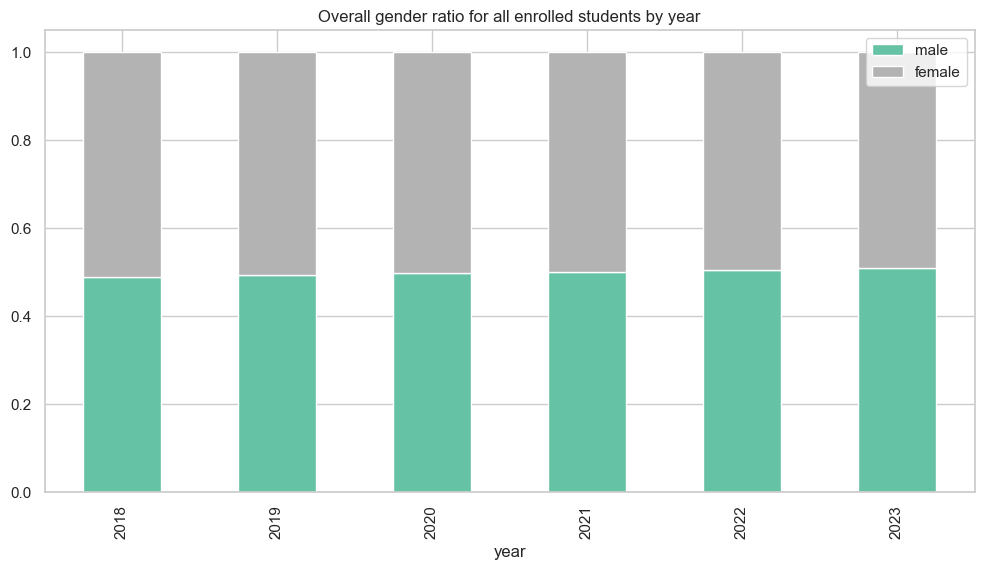

In [250]:
ax = df_s_genderyear.plot(kind='bar', stacked=True, colormap='Set2')
ax.legend(['male','female'])
plt.title('Overall gender ratio for all enrolled students by year')
plt.show()

The graphic (and the chart) illustrates that between 2018 and 2023 the gender ratio among the total student population was around the 50% mark. The numerical data suggest a small increase of the number of female students overall.

The lineplot below shows this observation in closeup.

In [251]:
dfs_lp_gender = year_crosstab(df_s,'gender',norm=False).reset_index().melt(id_vars='year', var_name='gender', value_name='count')

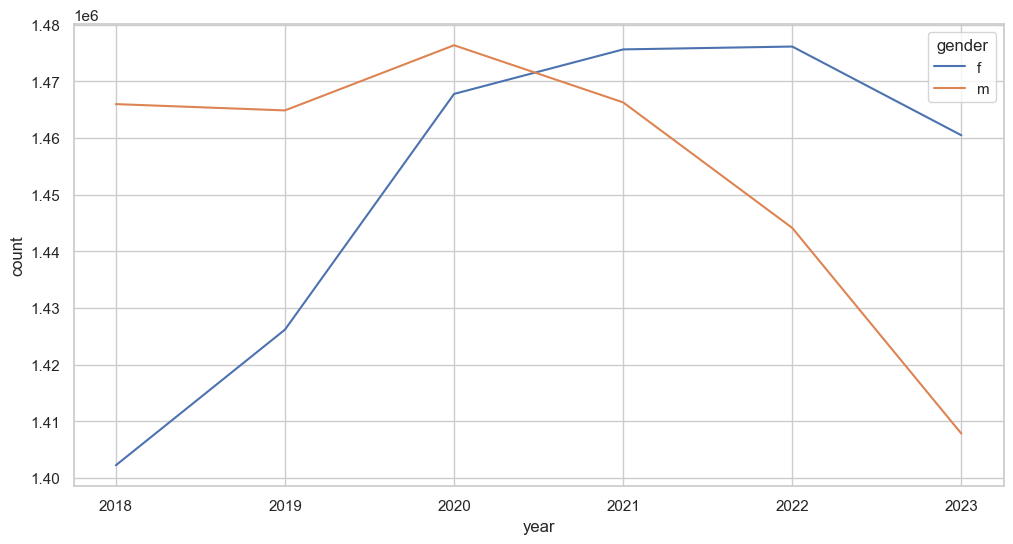

In [252]:
sns.lineplot(dfs_lp_gender,x='year',y='count',hue='gender');

In [253]:
df_s_natyear = year_crosstab(df_s,'nationality',norm=False)
df_s_natyear

nationality,domestic,foreign
year,,
2018,2473557,394665
2019,2479448,411601
2020,2527708,416437
2021,2501351,440564
2022,2462053,458210
2023,2398826,469485


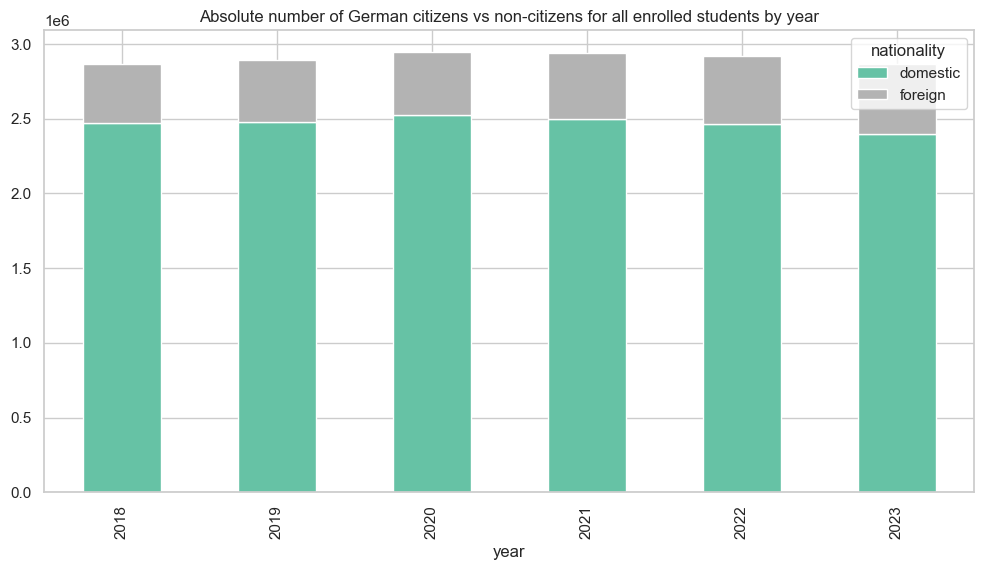

In [254]:
ax = df_s_natyear.plot(kind='bar', stacked=True, colormap='Set2')
#ax.legend(['GER non-citizen','GER citizen'])
plt.title('Absolute number of German citizens vs non-citizens for all enrolled students by year')
plt.show()

The barplot illustrates the overall decline in the number of students, but a slight increase in the number of foreign students over the time period.

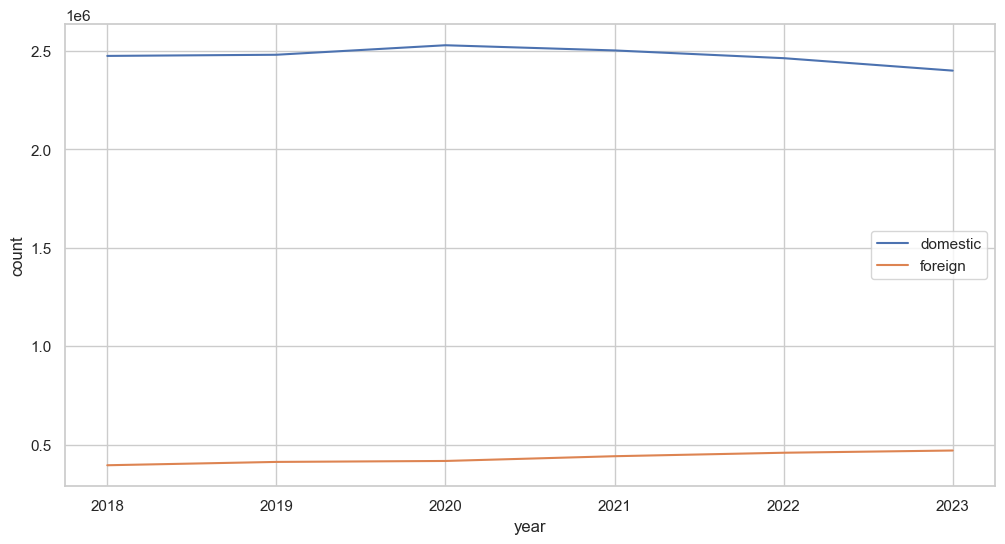

In [366]:
dfs_lp_nat = year_crosstab(df_s,'nationality',norm=False).reset_index().melt(id_vars='year', var_name='nationality', value_name='count')
sns.lineplot(dfs_lp_nat,x='year',y='count',hue='nationality')
plt.legend();

Naturally, to account for the overall decline in the number of students in spite of the slight increase in foreign students, the number of domestic students must have undergone a stronger decline. The lineplot shows the rise in absolute numbers for foreign students and the stronger decline in the number of students who are citizens in more detail.

### Incoming students/freshers

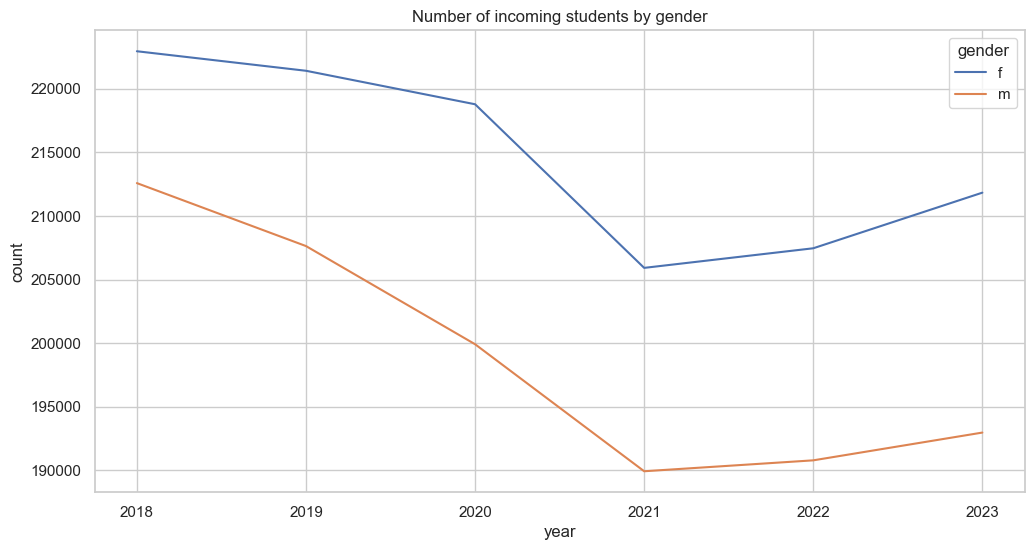

In [367]:
dff_lp_gender = year_crosstab(df_f,'gender',norm=False).reset_index().melt(id_vars='year', var_name='gender', value_name='count')
sns.lineplot(dff_lp_gender,x='year',y='count',hue='gender')
plt.title('Number of incoming students by gender');

This plot of the number of incoming students over the time period shows that the intake of female students has been consistently higher than the male intake over the whole period. So the swap in ratio observed for the total number of students in `df_s` above in 2021 is likely the result of a longer period of higher intake of female students rather than a specific change in intake patterns around 2021.

The graph also shows the overall dip in intake numbers irrespective of gender in 2021, likely related to the effects of COVID19. 

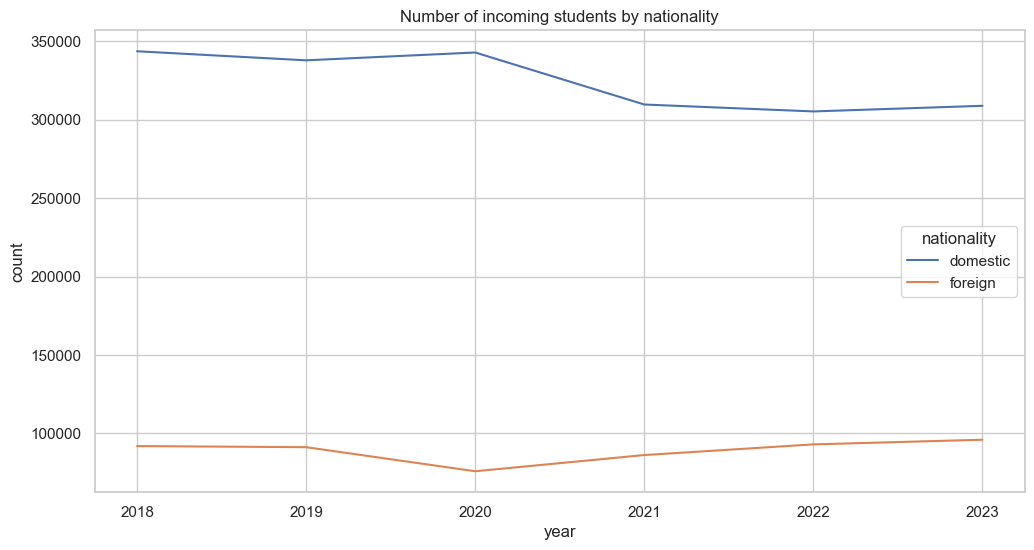

In [372]:
dff_lp_nat = year_crosstab(df_f,'nationality',norm=False).reset_index().melt(id_vars='year', var_name='nationality', value_name='count')
sns.lineplot(dff_lp_nat,x='year',y='count',hue='nationality')
plt.title('Number of incoming students by nationality');

## Consider subject groups

In [452]:
subjcodes_s.dtypes

grp_code           object
grp_name           object
grp_name_en        object
cluster_code       object
cluster_name       object
cluster_name_en    object
subj_code          object
subj_name          object
subj_name_en       object
dtype: object

In [454]:
df_s_ext = pd.merge(df_s,subjcodes_s, how='left',on=['subj_code','subj_code'])

In [455]:
df_s_ext.head()

,year,nationality,gender,subj_code,subj_name_x,number,grp_code,grp_name,grp_name_en,cluster_code,cluster_name,cluster_name_en,subj_name_y,subj_name_en
0,2018,domestic,m,211,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211),3,08,Ingenieurwissenschaften,Engineering Sciences,63,Maschinenbau/Verfahrenstechnik,Mechanical Engineering/Process Engineering,Energieverfahrenstechnik,Energy Process Engineering
1,2022,domestic,f,220,Milch- und Molkereiwirtschaft,21,07,"Agrar-, Forst- und Ernährungswissenschaften, Veterinärmedizin","Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",58,"Agrarwissenschaften, Lebensmittel- und Getränketechnologie","Agricultural Sciences, Food and Beverage Technology",Milch- und Molkereiwirtschaft,Dairy Farming and Dairy Industry
2,2022,foreign,f,280,Kartografie,44,08,Ingenieurwissenschaften,Engineering Sciences,69,Vermessungswesen,Surveying,Kartographie,Cartography
3,2023,foreign,m,086,"Katholische Theologie, - Religionslehre",407,01,Geisteswissenschaften,Humanities,03,"Kath. Theologie, Religionslehre","Catholic Theology, Religious Studies","Kath. Theologie, -Religionslehre","Catholic Theology, Religious Studies"
4,2023,foreign,f,272,Alte Geschichte,18,01,Geisteswissenschaften,Humanities,05,Geschichte,History,Alte Geschichte,Ancient History


In [462]:
total_bygrp = sum_univar(df_s_ext,'grp_code',norm=False).reset_index(drop=True)
total_bygrp

col_0,total
0,1919523
1,181793
2,6664869
3,1892176
4,1160704
5,376968
6,4621338
7,573774
8,42760


In [461]:
sns.barplot(total_bygrp,x='col_0',y='total')

ValueError: Could not interpret value `col_0` for `x`. An entry with this name does not appear in `data`.

sns.barplot